In [ ]:
# batch size 16 -> 32

# Dog Breeds Clssification w/CNN_VGG16bn(전이학습)

## 0. 환경 구성

In [1]:
import numpy as np
import pandas as pd
import glob
import cv2
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET

In [2]:
import torch # 파이토치 기본 라이브러리

# torchvision : 데이터셋, 모델 아키텍처, 컴퓨터 비전의 이미지 변환 기능 제공
from torchvision import datasets 
# torchvision에서 제공하는 데이터셋
from torchvision import transforms 
# 이미지 변환기능을 제공하는 패키지

# torch.utils.data : 파이토치 데이터 로딩 유틸리티
from torch.utils.data import DataLoader 
# 모델 훈련에 사용할 수 있는 미니 배치 구성하고
# 매 epoch마다 데이터를 샘플링, 병렬처리 등의 일을 해주는 함수
from torch.utils.data import Dataset
from torch.utils.data import random_split

from torch.utils.tensorboard import SummaryWriter
from copy import deepcopy

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

import sys

In [4]:
!nvidia-smi

Wed Apr 19 01:02:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## 1. 데이터
## 1.0. 데이터 불러오기

In [6]:
root_dir = '/kaggle/input/stanford-dogs-dataset'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [7]:
#import os
labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [ ]:
labels_map

## 1.1. 데이터 전처리

In [ ]:
'''
test_ 1:
augmentor = A.OneOf([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.RandomBrightness(limit=0.2, p=0.3)], p = 0.3)
'''
'''
try 1:
augmentor = A.OneOf([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.CLAHE(p=1)], p = 0.3)
'''
'''
try 2:
augmentor = A.OneOf([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.Rotate(limit = (45, 90), p=1, border_mode=cv2.BORDER_CONSTANT)], p = 0.3)
'''
'''
try 3(Back to Origin): # no augmentor
transform = transform = A.Compose([A.Resize(224, 224),  
                                    A.Normalize(), ToTensorV2()])
'''

In [ ]:
'''
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

#augmentor
augmentor = A.OneOf([
    A.VerticalFlip(p=1),
    A.HorizontalFlip(p=1),
    A.Rotate(limit = (45, 90), p=1, border_mode=cv2.BORDER_CONSTANT)], p = 0.3)

#변환기
#transform = A.Compose([A.Resize(224, 224), augmentor, A.Normalize(), 
#                     ToTensorV2()])
transform = A.Compose([A.Resize(224, 224),  A.Normalize(), ToTensorV2()])
'''

In [ ]:
'''
class DogsDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.transform = transform
        
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        img_path = self.img_dir[idx]
        annot_path = img_path.replace('images', 'annotations').replace('Images', 'Annotation').replace('.jpg', '')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label, img = img_crop(annot_path, img)
        
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img
        
        sample = {'image': img, 'label': label}
        return sample
'''

In [ ]:
'''
#annotation과 image file들을 imageset으로 받음[전체데이터]
imageset = DogsDataset(img_dir, transform = transform)
'''
#imageset = DogsDataset(img_dir)

In [8]:

def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    label = labels_map.get(species)

    cropped_img = img[ymin:ymax, xmin:xmax]
    rectangle = [xmin, ymin, xmax, ymax]
    return label, cropped_img, rectangle

def getRectangle(img, rectangle):
    img = cv2.rectangle(img, (rectangle[0], rectangle[1]), 
                        (rectangle[2], rectangle[3]),
                 color=[255,0,0], thickness=3)
    return img

In [9]:
transform = A.Compose([A.Resize(224, 224),  A.Normalize(), ToTensorV2()])

In [10]:

class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        self.transform = transform
        self.rectangle_img = None
        
    def __len__(self):
        return len(self.img_dir)
    
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        label, cropped_img, rectangle = img_crop(annot_path, img)
        self.rectangle_img = getRectangle(img.copy(), rectangle)
        if self.transform is not None:
            img = self.transform(image=cropped_img)
            img['label'] = label
            return img
        sample = {'image': cropped_img, 'label': label}
        return sample
    
    def getRectangle(self, idx):
        self.__getitem__(idx)
        return self.rectangle_img


In [11]:
#imageset = DogsDataset(annot_dir, img_dir, transform = transform)
imageset = DogsDataset(annot_dir, img_dir)

In [ ]:
imageset[0]

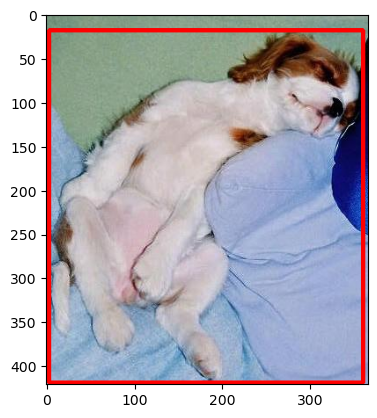

In [15]:
plt.imshow(imageset.getRectangle(990))

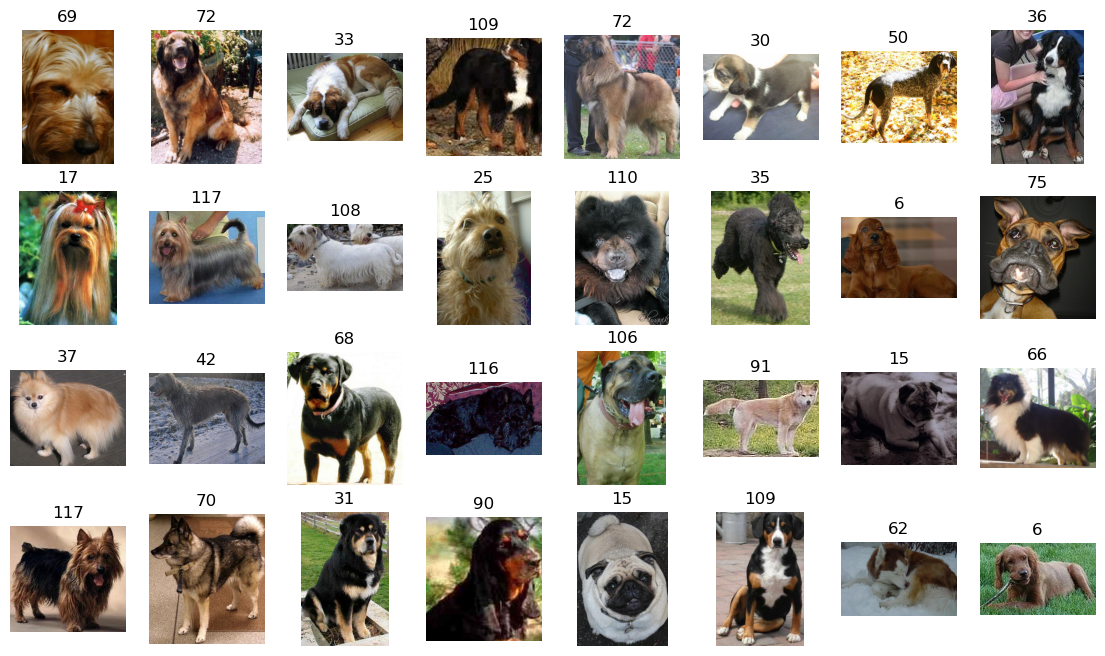

In [16]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(imageset))
    image= imageset[rand_i]['image']
    label =  imageset[rand_i]['label']
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(label)

In [ ]:
#시각화_transform 이후

In [17]:
imageset = DogsDataset(annot_dir, img_dir, transform = transform)

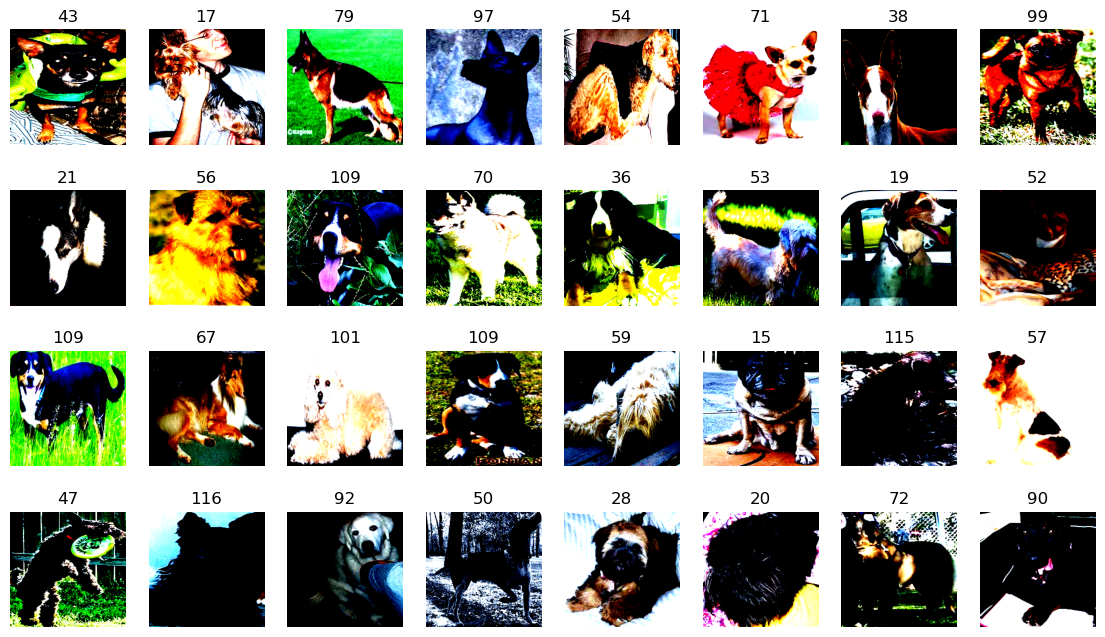

In [18]:
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(imageset))
    image, label= imageset[rand_i]['image'].permute(1,2,0), imageset[rand_i]['label']
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(label)

## 1.3. 데이터셋 분리

In [20]:
from tqdm import tqdm

In [21]:
total_label = [data["label"] for data in tqdm(imageset)]

trainset_idx, testset_idx = train_test_split(range(len(imageset)),
                test_size=0.2, random_state=42, 
                shuffle=True, stratify=total_label)

train_set = Subset(imageset, trainset_idx)
#test_set = Subset(imageset, testset_idx)

train_label = [data["label"] for data in tqdm(train_set)]

trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, 
                shuffle=True, stratify=train_label)

#train__set = Subset(train_set, trainset_idx)
#valid_set = Subset(train_set, validset_idx)

100%|██████████| 16464/16464 [01:23<00:00, 196.09it/s]


In [22]:
#train_set = Subset(imageset, trainset_idx)
test_set = Subset(imageset, testset_idx)

train__set = Subset(train_set, trainset_idx)
valid_set = Subset(train_set, validset_idx)

In [24]:
train__set[12]

{'image': tensor([[[-1.3130, -1.4500, -1.5870,  ..., -1.5185, -1.3473, -1.3130],
          [-1.3815, -1.4843, -1.6384,  ..., -1.4158, -1.3302, -1.2788],
          [-1.4158, -1.4843, -1.6727,  ..., -1.4158, -1.2959, -1.2617],
          ...,
          [-0.5938, -0.2684, -0.4226,  ..., -1.3473, -1.4500, -1.4672],
          [-0.4739, -0.5082, -0.4911,  ..., -1.4329, -1.4843, -1.4843],
          [-0.6794, -0.6623, -0.4226,  ..., -1.5528, -1.4500, -1.3987]],
 
         [[-1.6856, -1.7031, -1.7556,  ..., -1.7731, -1.7381, -1.7031],
          [-1.7556, -1.7381, -1.7906,  ..., -1.7031, -1.7031, -1.6681],
          [-1.7731, -1.7206, -1.8081,  ..., -1.7381, -1.6856, -1.6506],
          ...,
          [-0.8452, -0.5126, -0.6702,  ..., -1.7556, -1.8782, -1.8782],
          [-0.7227, -0.7577, -0.7402,  ..., -1.8431, -1.9132, -1.8957],
          [-0.9328, -0.9153, -0.6702,  ..., -1.9482, -1.8782, -1.8256]],
 
         [[-1.5256, -1.5604, -1.5953,  ..., -1.6302, -1.6824, -1.6824],
          [-1.5953,

In [23]:
print(type(train__set), len(train__set))
print(type(valid_set), len(valid_set))
print(type(test_set), len(test_set))

<class 'torch.utils.data.dataset.Subset'> 13171
<class 'torch.utils.data.dataset.Subset'> 3293
<class 'torch.utils.data.dataset.Subset'> 4116


## 3. 데이터 적재

In [25]:
batch_size = 32 # 100 -> 16 -> 32
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(train__set, batch_size=batch_size, shuffle=True) 
validloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False) 
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [26]:
13171/16, 3293/16, 4116/16

(823.1875, 205.8125, 257.25)

In [27]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 412
<class 'torch.utils.data.dataloader.DataLoader'> 103
<class 'torch.utils.data.dataloader.DataLoader'> 129


In [28]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), batch['label'].shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

## 4. 모델 생성 - 전이학습

In [29]:
import torch.nn as nn # 파이토치 제공 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저
import torch.nn.functional as F # 파이토치 제공 함수

import torchvision.models as models

In [30]:
model = models.vgg16_bn(weights=True)
#"https://download.pytorch.org/models/vgg16_bn-6c64b313.pth"

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [31]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [32]:
for parameter in model.parameters():
    parameter.requires_grad = False # 학습이 안되게 고정

for parameter in model.classifier.parameters():
    parameter.requires_grad = True # 학습이 가능한 상태

In [33]:
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [35]:
model.classifier[3] = nn.Linear(in_features=4096, out_features=512, bias=True)
model.classifier[6] = nn.Linear(in_features=512, out_features=120, bias=True)
model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=512, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=512, out_features=120, bias=True)
)

In [36]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [37]:
images = batch['image']
out = model(images.to(device))
print(device)
print(out.shape)

cuda
torch.Size([32, 120])


In [38]:
for name, parameter in model.named_parameters():
    print(name, parameter.size())

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.1.weight torch.Size([64])
features.1.bias torch.Size([64])
features.3.weight torch.Size([64, 64, 3, 3])
features.3.bias torch.Size([64])
features.4.weight torch.Size([64])
features.4.bias torch.Size([64])
features.7.weight torch.Size([128, 64, 3, 3])
features.7.bias torch.Size([128])
features.8.weight torch.Size([128])
features.8.bias torch.Size([128])
features.10.weight torch.Size([128, 128, 3, 3])
features.10.bias torch.Size([128])
features.11.weight torch.Size([128])
features.11.bias torch.Size([128])
features.14.weight torch.Size([256, 128, 3, 3])
features.14.bias torch.Size([256])
features.15.weight torch.Size([256])
features.15.bias torch.Size([256])
features.17.weight torch.Size([256, 256, 3, 3])
features.17.bias torch.Size([256])
features.18.weight torch.Size([256])
features.18.bias torch.Size([256])
features.20.weight torch.Size([256, 256, 3, 3])
features.20.bias torch.Size([256])
features.21

## 5. 모델 컴파일 (손실함수, 옵티마이저)

In [39]:
# 학습률 0.001로 고정(성능 개선됨)
learning_rate = 0.001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate, )
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) 
# patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                 factor=0.1, patience=4, verbose=True)

## 6. 모델 훈련

In [40]:
#손실함수, 정확도
def validate(model, validloader, loss_fn):
    total = 0
    correct = 0
    valid_loss = 0
    valid_accuracy = 0
    
    #전방향 예측_no need gradient
    with torch.no_grad():
        for batch in validloader:
            images = batch['image']
            labels = batch['label']
            
            #0. sending Data to GPU
            images, labels = images.to(device), labels.to(device)
            
            #1. 입력 데이터 준비
            #not Flatten
            #images.resize_(images.size()[0], 784)
            
            #2. forward prediction
            logit = model(images) #예측 점수
            _, preds = torch.max(logit, 1)
            # preds = logit.max(dim=1)[1]
            correct += int((preds ==labels).sum())
            total += labels.shape[0]
            
            
            loss = loss_fn(logit, labels)
            valid_loss += loss.item()
            #tensor에서 값을 꺼내와 batch loss 평균값을 valid_loss에 누적
            
        valid_accuracy = correct / total
        
    return valid_loss, valid_accuracy

In [41]:
def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for batch in trainloader: 
            # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1

            # images, labels: (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            images = batch['image']
            labels = batch['label']

            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            logit = model(images) # 예측 점수
            loss = loss_fn(logit, labels) 
            # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() 
                # 평가 모드 : 평가에 사용 X 계층(배치 정규화, 드롭아웃)들 비사용하기위함
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)

                # tensorboard 시각화를 위한 로그 이벤트 등록
#                 writer.add_scalar('Train Loss', train_loss/len(trainloader), epoch+1)
#                 writer.add_scalar('Valid Loss', valid_loss/len(validloader), epoch+1)
#                 writer.add_scalars('Train Loss and Valid Loss',
#                                   {'Train' : train_loss/len(trainloader),
#                                     'Valid' : valid_loss/len(validloader)}, epoch+1)
#                 writer.add_scalar('Valid Accuracy', valid_accuracy, epoch+1)
                # -------------------------------------------

                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                      'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                      'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                      'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                      )
        
                # Best model 저장    
                # option 1 : valid_loss 모니터링
                # if valid_loss < min_loss: 
                # 바로 이전 epoch의 loss보다 작으면 저장
                #   min_loss = valid_loss
                #   best_model_state = deepcopy(model.state_dict())          
                #   torch.save(best_model_state, 'best_checkpoint.pth')     
        
                # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : 
                    # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
                # -------------------------------------------

                # Early Stopping (조기 종료)
                if valid_loss > min_loss: 
                    # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                    if trigger > patience:
                        print('Early Stopping !!!')
                        print('Training loop is finished !!') 
                        return
                else:
                    trigger = 0
                    min_loss = valid_loss
                    best_model_state = deepcopy(model.state_dict())
                    torch.save(best_model_state, 'best_checkpoint.pth') 
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
                # -------------------------------------------
        
    return  

In [42]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/55....... Train Loss : 3.172 Valid Loss : 1.388 Valid Accuracy : 0.595
Epoch : 2/55....... Train Loss : 1.892 Valid Loss : 1.195 Valid Accuracy : 0.621
Epoch : 3/55....... Train Loss : 1.525 Valid Loss : 1.035 Valid Accuracy : 0.681
Epoch : 4/55....... Train Loss : 1.384 Valid Loss : 1.036 Valid Accuracy : 0.684
trigger :  1
Epoch : 5/55....... Train Loss : 1.256 Valid Loss : 1.032 Valid Accuracy : 0.688
Epoch : 6/55....... Train Loss : 1.173 Valid Loss : 0.972 Valid Accuracy : 0.701
Epoch : 7/55....... Train Loss : 1.091 Valid Loss : 1.004 Valid Accuracy : 0.708
trigger :  1
Epoch : 8/55....... Train Loss : 1.050 Valid Loss : 1.018 Valid Accuracy : 0.714
trigger :  2
Epoch : 9/55....... Train Loss : 1.058 Valid Loss : 1.017 Valid Accuracy : 0.713
trigger :  3
Epoch : 10/55....... Train Loss : 1.011 Valid Loss : 1.026 Valid Accuracy : 0.722
trigger :  4
Epoch : 11/55....... Train Loss : 0.967 Valid Loss : 1.059 Valid Accuracy : 0.721
trigger :  5
Epoch 00011: reducing learnin

**vgg16_bn 전이학습**

- 전처리 추가(augmentor -> flips, CHLAE(?)__선명도)
- 학습률 그대로 0.0001
- ====> accuracy 시작 0.626, 더디게 오르는 편(대체로 0.001씩)
- ====> loss 값이 적고, train과 valid의 loss값 차이가 점점 줄어듦.
- 0.7 차이에서 시작, epoch 17 단계에서 0.04 차이
- 일정 횟수가 지나면서 로스값 차이가 나기 시작(0.3~0.4)

## 7. 모델 예측

In [43]:
test_iter = iter(testloader)
batch = next(test_iter)
images = batch['image']
labels = batch['label']

images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [44]:
rnd_idx = 10
model.eval()
with torch.no_grad():
    logit = model(images[rnd_idx].unsqueeze(0)) 
    # model.forward()에서는 배치가 적용된 4차원 입력 기대

pred = logit.max(dim=1)[1]
print(pred == labels[rnd_idx]) # True : 잘 예측

tensor([True], device='cuda:0')


## 8. 모델 평가

In [45]:
#모델  평가
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

    # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for batch in testloader: 
            # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            images = batch['image']
            labels = batch['label']

            # 0. Data를 GPU로 보내기
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten
            # images.resize_(images.size()[0], 784)
      
            # 2. 전방향(Forward) 예측

            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) 
            # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) 
            # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] 
            # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            test_loss += loss.item() 
            # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        test_accuracy = correct / total
   
    print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
          'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 0.963 Test Accuracy : 0.764


In [46]:
#모델 저장
model.state_dict().keys()

odict_keys(['features.0.weight', 'features.0.bias', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.3.bias', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.7.bias', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.10.bias', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.14.bias', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.17.bias', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 

In [47]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [48]:
last_state_dict = torch.load('last_checkpoint.pth')
#last_state_dict.keys()

In [49]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model = model
last_model.to(device)
last_model.load_state_dict(last_state_dict)

<All keys matched successfully>

In [51]:
last_model.eval()
evaluation(last_model, testloader, loss_fn)  

Test Loss : 0.963 Test Accuracy : 0.764


In [52]:
# valid loss or accuracy 기준 best model
best_state_dict = torch.load('best_checkpoint.pth')
best_model = model
best_model.to(device)
best_model.load_state_dict(best_state_dict)

<All keys matched successfully>

In [53]:
best_model.eval()
evaluation(best_model, testloader, loss_fn)

Test Loss : 0.971 Test Accuracy : 0.759
